In [1]:
track = 'https://envirocar.org/api/stable/tracks/63948bc3ad53a0015a08780f'
streets = 'https://overpass-api.de/api/interpreter?data=[out%3Ajson][timeout%3A25]%3B%0A(%0A%20%20way["highway"~"^(motorway|trunk|primary|residential|tertiary|motorway_link|unclassified|service|secondary|secondary_link|trunk|trunk_link)%24"](51.45%2C7.268%2C51.4531%2C7.274)%3B%0A)%3B%0Aout%20geom%3B'

In [2]:
pip install geopandas

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install contextily

Note: you may need to restart the kernel to use updated packages.


In [4]:
import geopandas as gp
from shapely.geometry import shape
import requests
import contextily as cx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.spatial import distance
import json
import time

In [5]:
response = requests.get(streets)
mystreets = response.json()['elements']
for d in mystreets:
    coords = []
    for p in d['geometry']:
        coords.append((p['lon'],p['lat']))
    data = {"type": "LineString", "coordinates": coords}
    d['geometry'] = shape(data)
gdf = gp.GeoDataFrame(mystreets).set_geometry('geometry')
#gdf.head()

In [6]:
mystreets

[{'type': 'way',
  'id': 4268905,
  'bounds': {'minlat': 51.4530722,
   'minlon': 7.2680134,
   'maxlat': 51.4538694,
   'maxlon': 7.2698126},
  'nodes': [901598844,
   25670326,
   25670328,
   25670330,
   886362208,
   886362219,
   156899116,
   886362151,
   886361937,
   25550174,
   901591317,
   886891091,
   25550173],
  'geometry': <shapely.geometry.linestring.LineString at 0x2be0a748448>,
  'tags': {'highway': 'residential',
   'incline': 'down',
   'lit': 'yes',
   'maxspeed': '30',
   'maxspeed:type': 'DE:zone30',
   'name': 'Eulenbaumstraße',
   'postal_code': '44801',
   'sidewalk': 'both',
   'sidewalk:both:surface': 'paving_stones',
   'surface': 'asphalt'}},
 {'type': 'way',
  'id': 4732490,
  'bounds': {'minlat': 51.4522091,
   'minlon': 7.273639,
   'maxlat': 51.4522582,
   'maxlon': 7.2739587},
  'nodes': [2315951108, 477631],
  'geometry': <shapely.geometry.linestring.LineString at 0x2be0a938048>,
  'tags': {'bicycle': 'yes',
   'cycleway:both': 'no',
   'highway'

In [7]:
mytrack = gp.read_file(track)
#mytrack

In [40]:
tmp_list = []
for x in range(0,mytrack.shape[0],4):
    tmp_list.append({
      'id': mytrack.loc[x,'id'],
      'time': mytrack.loc[x,'time'],
      'phenomenons': mytrack.loc[x,'phenomenons'],
      'geometry': mytrack.loc[x,'geometry']
     })
subTracks = gp.GeoDataFrame(tmp_list)
#subTracks

In [9]:
#subTracks

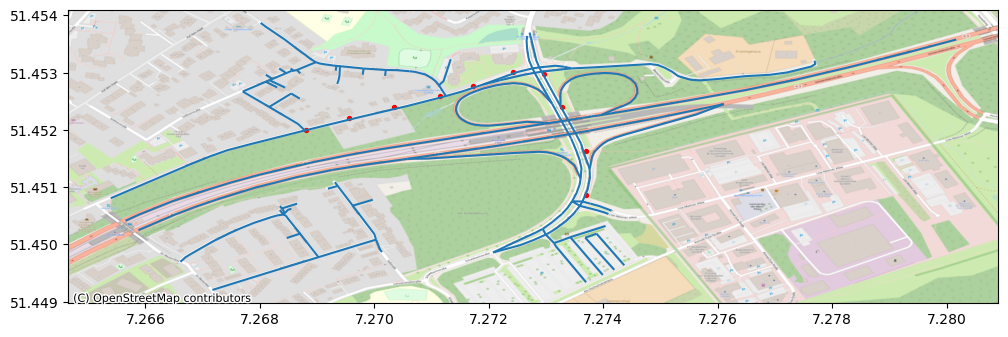

In [10]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
#worldMap = gp.read_file(gp.datasets.get_path("naturalearth_lowres"))
ax = subTracks.plot(ax=gdf.plot(), color='red', markersize=8)
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, crs=4326)

In [11]:
puffer = subTracks.buffer(0.0002)

In [12]:
puffergdf = gp.GeoDataFrame(geometry=puffer)

In [13]:
puffergdf.insert(0, "Id", range(1,1+len(puffergdf)))

In [14]:
tempStreets2 = gp.GeoDataFrame()
for puff in puffergdf.iterrows():
    tempStreets = []
    tempStreets = gp.overlay(gdf, gp.GeoDataFrame(geometry=[puff[1]['geometry']]), how='intersection')
    tempStreets['pufferId'] = puff[1]['Id']
    tempStreets2 = pd.concat([tempStreets2,tempStreets])

In [15]:
import shapely

In [16]:
snappedPoints = []
i=0
for index, row in tempStreets2.iterrows():
    activePoint = subTracks.loc[row['pufferId']-1]
    snappedPoints.append({
        'id': i,
        'pufferId': row['pufferId'],
        'pointId': activePoint['id'],
        'geometry': row['geometry'].interpolate(row['geometry'].project(activePoint.geometry))
     })
    i = i+1
snappedPointsGdf = gp.GeoDataFrame(snappedPoints)

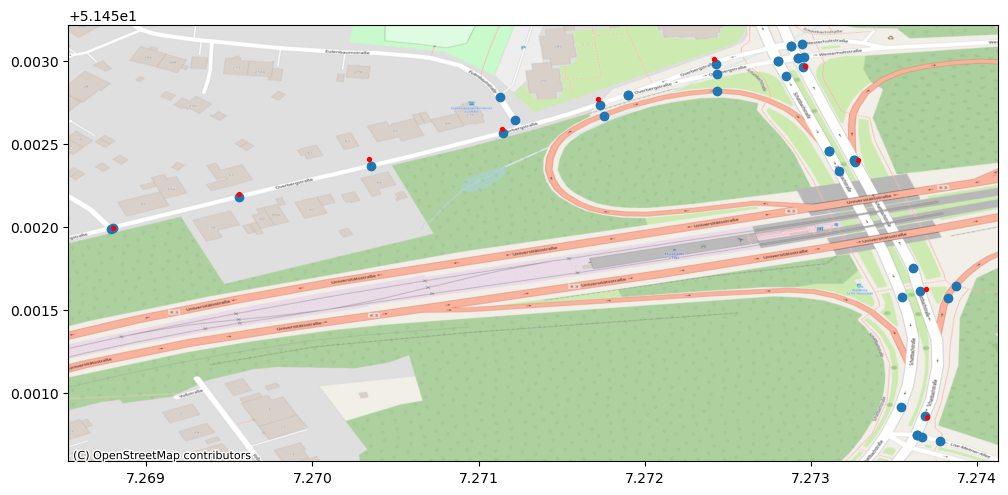

In [17]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
#worldMap = gp.read_file(gp.datasets.get_path("naturalearth_lowres"))
ax = subTracks.plot(ax=snappedPointsGdf.plot(), color='red', markersize=8)
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, crs=4326)

In [18]:
#snappedPointsGdf

In [19]:
koordinaten = {}
for index, row in snappedPointsGdf.iterrows():
    koordinaten[row['id']] = (row['geometry'].x, row['geometry'].y)
koordinaten

{0: (7.2735399038347035, 51.450915336810766),
 1: (7.2736361, 51.4507478),
 2: (7.2736851472366695, 51.45086302123814),
 3: (7.2736361, 51.4507478),
 4: (7.273666031134513, 51.450739773354904),
 5: (7.2737765, 51.4507102),
 6: (7.273823998849213, 51.45157436743337),
 7: (7.2736138, 51.4517558),
 8: (7.273549593098853, 51.451577961509244),
 9: (7.273655456747112, 51.45161523811082),
 10: (7.2738731, 51.4516461),
 11: (7.2732571, 51.4524041),
 12: (7.2731702968479235, 51.45233982055885),
 13: (7.2731058, 51.4524579),
 14: (7.2732644306868295, 51.45239099087379),
 15: (7.2732571, 51.4524041),
 16: (7.2731058, 51.4524579),
 17: (7.272951092887864, 51.45296327985172),
 18: (7.2728806, 51.4530917),
 19: (7.2729219, 51.4530174),
 20: (7.272955760336849, 51.45302120749191),
 21: (7.2728004, 51.4529967),
 22: (7.2729219, 51.4530174),
 23: (7.27285119218895, 51.452906248136955),
 24: (7.2728004, 51.4529967),
 25: (7.2728806, 51.4530917),
 26: (7.2729482991569725, 51.45309866100203),
 27: (7.2724

In [20]:
#dict(list(koordinaten.items())[:5])

In [21]:
#puffergdf

In [22]:
init_graph1 = {}
lastIndex = -1
for index, puffrow in puffergdf.iterrows():
    if lastIndex != -1: #nicht erste iteration
        tempPoints = snappedPointsGdf.loc[snappedPointsGdf['pufferId'] == puffrow['Id']]
        for j, firstCol in (snappedPointsGdf.loc[snappedPointsGdf['pufferId'] == lastIndex]).iterrows():
            init_graph1[firstCol['id']] = list(tempPoints['id'])
    lastIndex = puffrow['Id']
#init_graph1

In [23]:
def getDistances(sourcePs, destPs, metrics = "duration"):
    # bei "duration" antwort in Sekunden
    # dei "distance" antwort in Metern
    url = "https://ors5.fbg-hsbo.de//v2/matrix/driving-car"
    N = len(sourcePs)
    M = len(destPs)
    locationsP = sourcePs + destPs
    body = {"locations":locationsP, "destinations":list(range(N,N+M)), "sources":list(range(0,N)), "metrics":[metrics]}
    # spalten nach destinations, zeile nach sources
    headers = {'Accept': 'application/json, application/geo+json, application/gpx+xml, img/png; charset=utf-8',
    'Authorization': '5b3ce3597851110001cf624837b0be5d89604065b03e13c82ba84c06',
    'Content-Type': 'application/json; charset=utf-8'}
    call = requests.post(url, json=body)
    edgeValues = json.loads(call.text)[metrics+"s"]
    return edgeValues

In [24]:
def createForks(sourcePIDs, destPIDs, distMatrix):
    retDict = {}
    for sPID in sourcePIDs:
        retDict[sPID] = {}
    for j in range(0, len(sourcePIDs)):
        sourcePID = sourcePIDs[j]
        for i in range(0, len(destPIDs)):
            #print(i)
            retDict[sourcePID][destPIDs[i]] = distMatrix[j][i]
    return retDict

In [25]:
def createDistGraph(pDict, forkDict, metrics = "duration"):
    outputGraph = {}
    for sourcePID, destPIDList in forkDict.items():
        tempDestPDict = {}
        for destPID in destPIDList:
            tempDestPDict[destPID] = pDict[destPID]
            pDict[sourcePID]
            outputGraph.update(createForks([sourcePID],list(tempDestPDict.keys()),getDistances([pDict[sourcePID]],list(tempDestPDict.values()), metrics = metrics)))
    return outputGraph

In [26]:
def createProbGraph(pDict, forkDict, metrics = "duration"):
    #TODO: Kantenwerte als Wahrscheinlichkeioten...
    outputGraph = {}
    for sourcePID, destPIDList in forkDict.items():
        tempDestPDict = {}
        for destPID in destPIDList:
            tempDestPDict[destPID] = pDict[destPID]
            pDict[sourcePID]
            distances = getDistances([pDict[sourcePID]],list(tempDestPDict.values()), metrics = metrics)
            total = sum(distances[0])                         
            ws = []
            for value in distances[0]:
                ws.append(value/total)
            outputGraph.update(createForks([sourcePID],list(tempDestPDict.keys()),[ws]))
            #time.sleep(10)
    return outputGraph

In [27]:
outputGraph = createProbGraph(koordinaten, init_graph1)

In [28]:
#outputGraph

In [29]:
d_graph = {}
d_graph[-1] = {}
for index, node in snappedPointsGdf.iterrows():
    d_graph[node['id']] = {}
lastIndex = -1
for index, puffrow in puffergdf.iterrows():
    tempPoints = snappedPointsGdf.loc[snappedPointsGdf['pufferId'] == puffrow['Id']]
    summe = 0
    for index, tp1 in tempPoints.iterrows():
        actSnappedPoint = (tp1['geometry'].x, tp1['geometry'].y)
        actBasePoint = (subTracks['geometry'].iloc[puffrow['Id']-1].x, subTracks['geometry'].iloc[puffrow['Id']-1].y)
        abstand = distance.euclidean(actSnappedPoint, actBasePoint)
        summe = summe + abstand
    if lastIndex == -1:
        for index, tp in tempPoints.iterrows():
            actSnappedPoint = (tp['geometry'].x, tp['geometry'].y)
            actBasePoint = (subTracks['geometry'].iloc[puffrow['Id']-1].x, subTracks['geometry'].iloc[puffrow['Id']-1].y)
            abstand = distance.euclidean(actSnappedPoint, actBasePoint)
            d_graph[-1][tp['id']] = 1-(abstand/summe)
    else:
        for i, secondCol in tempPoints.iterrows():
            for j, firstCol in (snappedPointsGdf.loc[snappedPointsGdf['pufferId'] == lastIndex]).iterrows():
                actBasePoint = (subTracks['geometry'].iloc[puffrow['Id']-1].x, subTracks['geometry'].iloc[puffrow['Id']-1].y)
                secColPoint = (secondCol['geometry'].x, secondCol['geometry'].y)
                abstand = distance.euclidean(actBasePoint, secColPoint)
                #d_graph[firstCol['id']][secondCol['id']] = (1-(abstand/summe)) * 100
                #print(abstand/summe)
                d_graph[firstCol['id']][secondCol['id']] = (1-(abstand/summe)) * outputGraph[firstCol['id']][secondCol['id']]
    lastIndex = puffrow['Id']
for index, pts in snappedPointsGdf.loc[snappedPointsGdf['pufferId'] == puffergdf['Id'].max()].iterrows():
    d_graph[pts['id']][-2] = 0

In [41]:
#d_graph

In [43]:
#els = list(d_graph.items())
#els[-1]

In [42]:
#d_graph[-1]

In [44]:
unbesuchteKnoten = list(d_graph)
unbesuchteKnoten.append(-2)
tabelle = pd.DataFrame(unbesuchteKnoten, columns=['Knoten'])
tabelle['Vorgaenger'] = -99
tabelle['Gesamtdistanz'] = float('inf')
startID = -1
endID = -2
#tabelle

In [45]:
tabelle.loc[tabelle['Knoten'] == -1,'Gesamtdistanz'] = 0
for nachbarn in d_graph[startID].items():
    tabelle.loc[tabelle['Knoten'] == nachbarn[0],'Gesamtdistanz'] = nachbarn[1]
    tabelle.loc[tabelle['Knoten'] == nachbarn[0],'Vorgaenger'] = -1
unbesuchteKnoten.remove(-1)
while (len(unbesuchteKnoten) != 0 and (-2 in unbesuchteKnoten)):
    tempTabelle = tabelle[tabelle['Vorgaenger'] != -99]
    tempTabelle.sort_values(by=['Gesamtdistanz'], inplace=True)
    i =0
    while(tempTabelle.iloc[i]['Knoten'] not in unbesuchteKnoten):
        i = i+1
    activePoint = tempTabelle.iloc[i]
    if (activePoint['Knoten'] != -2):
        for nachbarn in d_graph[activePoint['Knoten']].items():
            if nachbarn[0] in unbesuchteKnoten:
                if ((activePoint['Gesamtdistanz']+nachbarn[1]) < tabelle[tabelle['Knoten'] == nachbarn[0]]['Gesamtdistanz']).bool():
                    tabelle.loc[tabelle['Knoten'] == nachbarn[0],'Gesamtdistanz'] = activePoint['Gesamtdistanz']+nachbarn[1]
                    tabelle.loc[tabelle['Knoten'] == nachbarn[0],'Vorgaenger'] = activePoint['Knoten']
            tabelle
    unbesuchteKnoten.remove(activePoint['Knoten'])
#tabelle

C:\..Mein\programme\anaconda\envs\ppa\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\..Mein\programme\anaconda\envs\ppa\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\..Mein\programme\anaconda\envs\ppa\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\..Mein\programme\anaconda\envs\ppa\lib\site-packages

C:\..Mein\programme\anaconda\envs\ppa\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\..Mein\programme\anaconda\envs\ppa\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\..Mein\programme\anaconda\envs\ppa\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\..Mein\programme\anaconda\envs\ppa\lib\site-packages

In [35]:
weg = [-2]
while ((tabelle[tabelle["Knoten"] == weg[-1]]["Vorgaenger"]).item() != -99):
    weg.append(tabelle[tabelle["Knoten"] == weg[-1]]["Vorgaenger"].item())
weg.reverse()
weg.remove(-1)
weg.remove(-2)
weg

[5.0, 7.0, 14.0, 22.0, 28.0, 32.0, 35.0, 37.0, 38.0, 39.0]

In [36]:
wegkoordinaten = []
for id in weg:
    wegkoordinaten.append([koordinaten[id][0], koordinaten[id][1]])
wegkoordinaten

[[7.2737765, 51.4507102],
 [7.2736138, 51.4517558],
 [7.2732644306868295, 51.45239099087379],
 [7.2729219, 51.4530174],
 [7.272426716195182, 51.45298369246032],
 [7.2718989, 51.4527925],
 [7.2711282, 51.4527806],
 [7.270351901134425, 51.45236483875899],
 [7.26956021881448, 51.452178681312695],
 [7.2687861, 51.4519899]]

In [37]:
body = {"coordinates":wegkoordinaten}
headers = {
    'Accept': 'application/json, application/geo+json, application/gpx+xml, img/png; charset=utf-8',
    'Authorization': '5b3ce3597851110001cf624837b0be5d89604065b03e13c82ba84c06',
    'Content-Type': 'application/json; charset=utf-8'
}
call = requests.post('https://api.openrouteservice.org/v2/directions/driving-car/geojson', json=body, headers=headers)
wegpoints = json.loads(call.text)["features"][0]["geometry"]
print(wegpoints)

{'coordinates': [[7.273776, 51.45071], [7.273676, 51.450737], [7.273636, 51.450748], [7.273729, 51.450965], [7.273766, 51.451166], [7.273761, 51.451319], [7.273683, 51.451538], [7.273643, 51.451651], [7.273614, 51.451756], [7.273614, 51.451756], [7.273554, 51.451868], [7.273322, 51.452288], [7.273264, 51.452391], [7.273257, 51.452404], [7.273075, 51.452733], [7.272922, 51.453017], [7.272881, 51.453092], [7.272763, 51.453074], [7.272585, 51.453031], [7.272431, 51.452978], [7.272056, 51.452849], [7.271899, 51.452792], [7.271735, 51.452738], [7.271541, 51.452673], [7.27125, 51.452591], [7.271128, 51.452781], [7.27125, 51.452591], [7.271116, 51.452555], [7.270349, 51.452369], [7.269561, 51.452178], [7.269084, 51.452063], [7.268786, 51.45199]], 'type': 'LineString'}


In [38]:
geom = [shape(i) for i in [wegpoints]]
fahrtwegGDF = gp.GeoDataFrame({'geometry':geom})
fahrtwegGDF

,geometry
0,"LINESTRING (7.27378 51.45071, 7.27368 51.45074..."


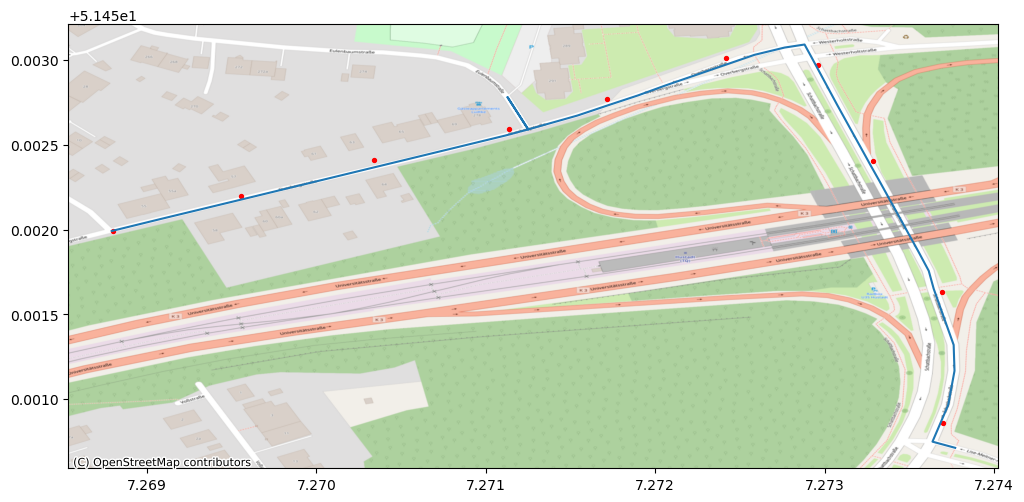

In [39]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
#worldMap = gp.read_file(gp.datasets.get_path("naturalearth_lowres"))
ax = subTracks.plot(ax=fahrtwegGDF.plot(), color='red', markersize=8)
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, crs=4326)

In [47]:
tmp_list = []
for x in range(0,mytrack.shape[0],1):
    tmp_list.append({
      'id': mytrack.loc[x,'id'],
      'time': mytrack.loc[x,'time'],
      'phenomenons': mytrack.loc[x,'phenomenons'],
      'geometry': mytrack.loc[x,'geometry']
     })
myTrack2 = gp.GeoDataFrame(tmp_list)
myTrack2

,id,time,phenomenons,geometry
0,63948bc3ad53a0015a087811,2022-10-15T15:38:46+00:00,"{'GPS Altitude': {'value': 159.095573, 'unit':...",POINT (7.27370 51.45086)
1,63948bc3ad53a0015a087813,2022-10-15T15:38:48+00:00,"{'GPS Accuracy': {'value': 6.0, 'unit': '%'}, ...",POINT (7.27377 51.45104)
2,63948bc3ad53a0015a087814,2022-10-15T15:38:50+00:00,"{'Rpm': {'value': 1609.0, 'unit': 'u/min'}, 'S...",POINT (7.27378 51.45125)
3,63948bc3ad53a0015a087815,2022-10-15T15:38:52+00:00,"{'Speed': {'value': 38.0, 'unit': 'km/h'}, 'Ma...",POINT (7.27375 51.45145)
4,63948bc3ad53a0015a087816,2022-10-15T15:38:54+00:00,"{'GPS Accuracy': {'value': 6.0, 'unit': '%'}, ...",POINT (7.27369 51.45163)
5,63948bc3ad53a0015a087817,2022-10-15T15:38:56+00:00,"{'Rpm': {'value': 1678.0, 'unit': 'u/min'}, 'G...",POINT (7.27360 51.45183)
6,63948bc3ad53a0015a087818,2022-10-15T15:38:58+00:00,"{'Calculated MAF': {'value': 6.375149, 'unit':...",POINT (7.27349 51.45203)
7,63948bc3ad53a0015a087819,2022-10-15T15:39:00+00:00,"{'Rpm': {'value': 1682.0, 'unit': 'u/min'}, 'G...",POINT (7.27339 51.45222)
8,63948bc3ad53a0015a08781a,2022-10-15T15:39:02+00:00,"{'CO2': {'value': 4.402291, 'unit': 'kg/h'}, '...",POINT (7.27328 51.45240)
9,63948bc3ad53a0015a08781b,2022-10-15T15:39:04+00:00,"{'Speed': {'value': 32.0, 'unit': 'km/h'}, 'Ca...",POINT (7.27318 51.45255)


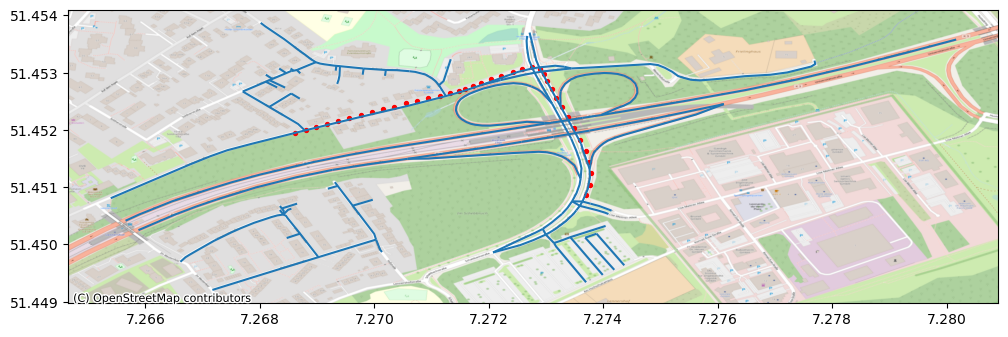

In [48]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
#worldMap = gp.read_file(gp.datasets.get_path("naturalearth_lowres"))
ax = myTrack2.plot(ax=gdf.plot(), color='red', markersize=8)
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, crs=4326)